#### Code

In [2]:
# load the autoreload extension
%load_ext autoreload

# automatically reload all modules (except those excluded by IPython)
%autoreload 2

In [10]:
import sys
sys.path.append('/tahoe/diffusePerturb/diffusion_folder')
sys.path.append('/tahoe/diffusePerturb')


from diffusion import Diffusion 
from hydra import initialize, compose
from omegaconf import OmegaConf
import dataloader
from mosaicfm.data import build_dataloader
from mosaicfm.tokenizer import GeneVocab
import numpy as np 
import random 
import itertools
from streaming.base.util import clean_stale_shared_memory
import tempfile
import torch 


def generate_samples(config, data_batch, tokenizer, num_samples=1, num_steps=128, eps=1e-5, masking_ratio=0.5):
    model = Diffusion.load_from_checkpoint(config.eval.checkpoint_path, tokenizer=tokenizer, config=config)
    model.eval()
    model.backbone.eval()
    model.noise.eval()
    device = model.device
    
    cond_vec = data_batch['gene'][:num_samples].to(device)
    orig_expr = (data_batch['expr'][:num_samples] + 2).long().to(device) # convert to 0 indexed

    dumb_tokens_mask = (orig_expr < 2).bool()
    # create a masked version 
    move_indices = torch.rand(*orig_expr.shape, device=orig_expr.device) < masking_ratio
    masked_expr = torch.where(move_indices, model.mask_index, orig_expr)

    keep_indices = ~(move_indices.bool()) # evidece tokens that we will paste in 
    keep_indices |= dumb_tokens_mask

    # keep my dumb padding tokens
    masked_expr[dumb_tokens_mask] = orig_expr[dumb_tokens_mask]

    samples, inter_samples = model._cond_sample(cond_vec=cond_vec, inpaint_x=masked_expr, evidence_mask=keep_indices, num_steps=num_steps, eps=eps)
        #print("Text samples", samples)
    return samples, inter_samples 


def ret_config_tokenizer_dl():
    clean_stale_shared_memory()
    # load our config 
    with initialize(config_path="configs", version_base=None):
        config = compose(config_name="config")

    # get our tokenizer and build vocab 
    prev_model_config = config.prev_model 
    vocab_config = config.vocabulary 
    collator_config = config.collator 

    vocab = GeneVocab.from_file('/tahoe/diffusePerturb/vocab.json')
    special_tokens = ["<pad>", "<cls>", "<eoc>"]

    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)
    if collator_config.get("use_junk_tokens", False):
        # Based on Karpathy's observation that 64 is a good number for performance
        # https://x.com/karpathy/status/1621578354024677377?s=20
        original_vocab_size = len(vocab)
        remainder = original_vocab_size % 64
        if remainder > 0:
            junk_tokens_needed = 64 - remainder
            for i in range(junk_tokens_needed):
                junk_token = f"<junk{i}>"
                vocab.append_token(junk_token)

    ## Update PAD token ID
    collator_config.pad_token_id = vocab["<pad>"]
    ## Update model config with Vocab Size
    prev_model_config.vocab_size = len(vocab)

    valid_loader_config = config.valid_loader 

    valid_loader_config.dataset.streams.tahoe.local = tempfile.mkdtemp(prefix="/tahoe/valid_")
    device_eval_batch_size = config.device_eval_batch_size

    tokenizer = dataloader.get_tokenizer(config)

    # get dataloader 
    valid_loader = build_dataloader(
        vocab=vocab,
        loader_cfg=valid_loader_config,
        collator_cfg=collator_config,
        device_batch_size=device_eval_batch_size,
    )

    return config, tokenizer, valid_loader  


In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import torch


def visualize_diffusion_fast(
    tensor_list,
    filename="diffusion.gif",
    pad_values={0, 1},
    mask_value=53,
    fps=2,
    sample_idx=0,
    first_n_elms=50,
    pause_last_s=1.0
):
    """Fast GIF visualisation that re-uses one figure."""
    # ---------- pre-compute int→token mapping ----------
    lut = {v: "[PAD]" for v in pad_values}
    lut[mask_value] = "[MASK]"

    def tensor_to_line(t):
        # vectorised map: convert to Python ints once, then look up
        return " ".join(lut.get(int(x), f'{int(x)-2}') for x in t)

    # ---------- persistent figure ----------
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.axis("off")
    txt = ax.text(
        0.5,
        0.5,
        "",
        ha="center",
        va="center",
        wrap=True,
        fontsize=14,
    )

    writer = PillowWriter(fps=fps)          # uses pillow, no tmp PNGs
    with writer.saving(fig, filename, dpi=100):
        for t in tensor_list:
            t = t[sample_idx].tolist()[:first_n_elms]
            txt.set_text(tensor_to_line(t))
            # draw once, then let PillowWriter grab the RGBA buffer
            fig.canvas.draw()               # very fast for text update
            writer.grab_frame()

        extra_frames = int(round(pause_last_s * fps))
        for _ in range(extra_frames):
            writer.grab_frame()

    plt.close(fig)
    print(f"Saved diffusion visualisation to {filename}")

# Discrete diffusion for gene expression count generation

In [12]:
# get dataloader
config, tokenizer, dl = ret_config_tokenizer_dl() 

In [13]:
first_batch = next(iter(dl))
#first_batch = torch.load('val_batch.pt')

## Try generating samples 
output, inter_samples = generate_samples(config, first_batch, None, masking_ratio=0.5)

/tahoe/diffusePerturb/diffusion_folder/diffusion.py:240: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float32):
/tahoe/diffusePerturb/diffusion_folder/models/dit.py:370: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tahoe/diffusePerturb/diffusion_folder/models/dit.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/tahoe/diffusePerturb/diffusion_folder/models/dit.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


### Visualize generation

Saved diffusion visualisation to diffusion.gif


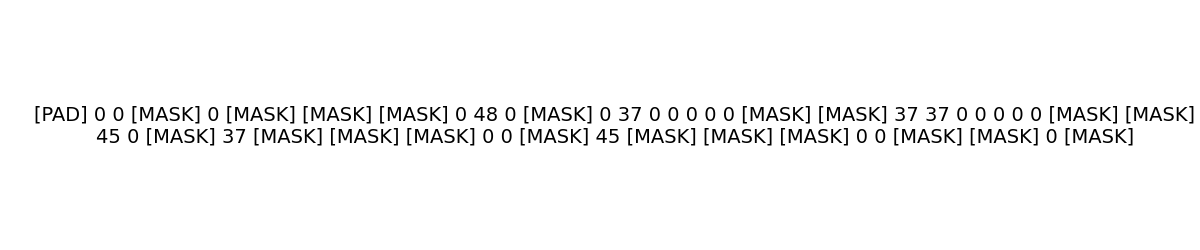

In [14]:
sub_inter_samples = [inter_samples[i] for i in range(0, len(inter_samples), 10)]
sub_inter_samples.append(inter_samples[-1])
visualize_diffusion_fast(sub_inter_samples, fps=4)

from IPython.display import Image, display
display(Image(filename='diffusion.gif'))

### Higher masking ratio (sample generation)

Here we can do masking ratio of 0.8

/tahoe/diffusePerturb/diffusion_folder/diffusion.py:240: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float32):
/tahoe/diffusePerturb/diffusion_folder/models/dit.py:370: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tahoe/diffusePerturb/diffusion_folder/models/dit.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/tahoe/diffusePerturb/diffusion_folder/models/dit.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Saved diffusion visualisation to higher_mask_diffusion.gif


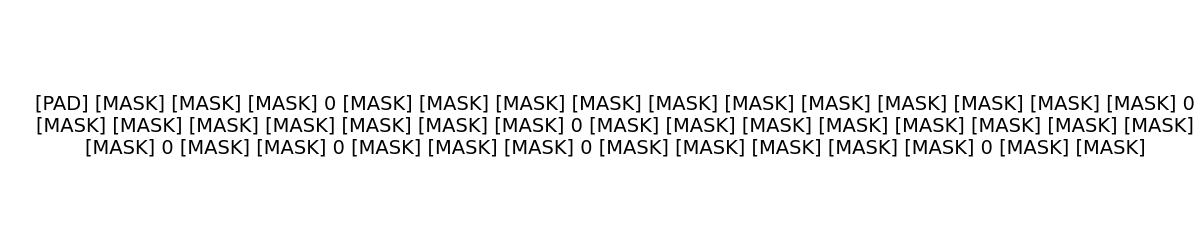

In [16]:
output, inter_samples = generate_samples(config, first_batch, None, masking_ratio=0.8)

sub_inter_samples = [inter_samples[i] for i in range(0, len(inter_samples), 10)]
sub_inter_samples.append(inter_samples[-1])
visualize_diffusion_fast(sub_inter_samples, fps=4, filename='higher_mask_diffusion.gif')

from IPython.display import Image, display
display(Image(filename='higher_mask_diffusion.gif'))

### Lower masking ratio (precise control)

We can do masking ratio of 0.2

In [ ]:
output, inter_samples = generate_samples(config, first_batch, None, masking_ratio=0.2)

sub_inter_samples = [inter_samples[i] for i in range(0, len(inter_samples), 10)]
sub_inter_samples.append(inter_samples[-1])
visualize_diffusion_fast(sub_inter_samples, fps=4, filename='lower_mask_diffusion.gif')

from IPython.display import Image, display
display(Image(filename='lower_mask_diffusion.gif'))

### How well does it perform in practice?

Measuring accuracy 

In [45]:
def measure_accuracy(output_fifty, data_batch):
    num_samples = output_fifty.shape[0]
    output_fifty = output_fifty.to("cpu")
    orig_samples = (data_batch['expr'][:num_samples] + 2).long().to("cpu")
    real_tokens_mask = (orig_samples >= 2) & (orig_samples  < 53)

    alignment = torch.isclose(output_fifty, orig_samples) & real_tokens_mask 
    accuracy = torch.sum(alignment).item() / torch.sum(real_tokens_mask).item()
    return accuracy 

In [ ]:
# for 50% masked 
output_fifty, inter_samples = generate_samples(config, first_batch, None, masking_ratio=0.5, num_samples=64)

In [46]:
measure_accuracy(output_fifty, first_batch)

0.838832961993202

In [47]:
# for 80% masked 
output_fifty, inter_samples = generate_samples(config, first_batch, None, masking_ratio=0.8, num_samples=64)
measure_accuracy(output_fifty, first_batch)

0.7464099269788093

In [48]:
# for 20% masked 
output_fifty, inter_samples = generate_samples(config, first_batch, None, masking_ratio=0.2, num_samples=64)
measure_accuracy(output_fifty, first_batch)

0.9370456504415424

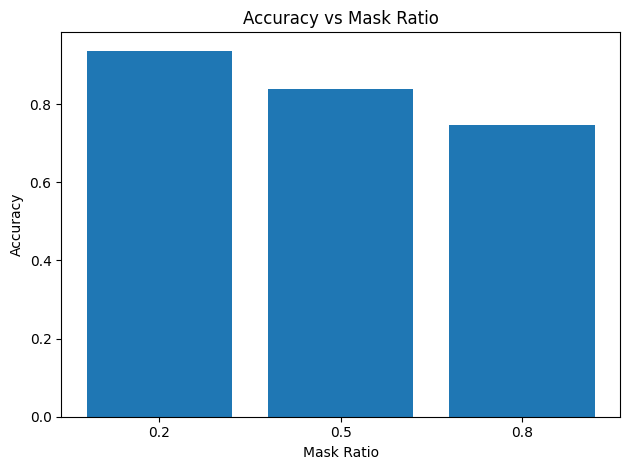

In [51]:
mask_ratios = np.array([0.2, 0.5, 0.8, ])
accuracy    = np.array([0.937, 0.838, 0.746])

# Positions for the bars on the x-axis
x = np.arange(len(mask_ratios))

# Create bar plot
plt.figure()
plt.bar(x, accuracy)

# Replace x-tick labels with the actual mask ratios
plt.xticks(x, mask_ratios)

# Labels and title
plt.xlabel("Mask Ratio")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Mask Ratio")

plt.tight_layout()
plt.show()